# Library Installation & Loading

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install "../input/segmentation-models-pytorch-021/wheels/pretrainedmodels-0.7.4-py3-none-any.whl"
!pip install "../input/segmentation-models-pytorch-021/wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl"
!pip install "../input/segmentation-models-pytorch-021/wheels/timm-0.4.12-py3-none-any.whl"
!pip install "../input/segmentation-models-pytorch-021/wheels/segmentation_models_pytorch-0.2.1-py3-none-any.whl"
!pip install "../input/monai-wheel/monai-0.9.0-202206131636-py3-none-any.whl"

Processing /kaggle/input/segmentation-models-pytorch-021/wheels/pretrainedmodels-0.7.4-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-021/wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-021/wheels/timm-0.4.12-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-021/wheels/segmentation_models_pytorch-0.2.1-py3-none-any.whl
Processing /kaggle/input/monai-wheel/monai-0.9.0-202206131636-py3-none-any.whl


In [5]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
import json

# visualization
import cv2
import matplotlib.pyplot as plt
from skimage import io

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold,StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

import timm

#monai
from monai.metrics.utils import get_mask_edges, get_surface_distance
from monai.networks.nets import SwinUNETR
import monai
#keras

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")


# Configurations

In [6]:

class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'v4'
    comment       = 'unet-efficientnet_b0-320x384'
    model_name    = 'UnetPlusPlus'
    backbone      = 'efficientnet-b0'
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = 320
    epochs        = 15
    lr            = 2e-3
    num_slices    = 5
    in_channels   = 3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 9
    folds         = [0]
    num_classes   = 3
    thr           = 0.40
#     device        = torch.device("cpu")
    device        = torch.device("cuda")

# Seeding

In [7]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #Set a fixed value for the hash seed
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# Metadata

In [8]:
tmp = "../input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png"

In [9]:
df=pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")

In [10]:
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [12]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    
    ans=False
    for i in range(3):
        try:
            if np.isnan(row["segmentation"][i]):
                ans=False
            else:
                ans=True
        except:
            ans=True
    row["empty"] = ans
    
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_

    return row

In [13]:
df = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index()
print(df.head())
order=["large_bowel","small_bowel","stomach"]

df = df.progress_apply(get_metadata, axis=1)
print(df.head())

paths = glob('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.progress_apply(path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()

                         id     segmentation
0  case101_day20_slice_0001  [nan, nan, nan]
1  case101_day20_slice_0002  [nan, nan, nan]
2  case101_day20_slice_0003  [nan, nan, nan]
3  case101_day20_slice_0004  [nan, nan, nan]
4  case101_day20_slice_0005  [nan, nan, nan]


100%|██████████| 38496/38496 [01:16<00:00, 501.53it/s]


                         id     segmentation  case  day  slice  empty
0  case101_day20_slice_0001  [nan, nan, nan]   101   20      1  False
1  case101_day20_slice_0002  [nan, nan, nan]   101   20      2  False
2  case101_day20_slice_0003  [nan, nan, nan]   101   20      3  False
3  case101_day20_slice_0004  [nan, nan, nan]   101   20      4  False
4  case101_day20_slice_0005  [nan, nan, nan]   101   20      5  False


100%|██████████| 38496/38496 [01:30<00:00, 425.95it/s]


,id,segmentation,case,day,slice,empty,image_path,height,width
0,case101_day20_slice_0001,"[nan, nan, nan]",101,20,1,False,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
1,case101_day20_slice_0002,"[nan, nan, nan]",101,20,2,False,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
2,case101_day20_slice_0003,"[nan, nan, nan]",101,20,3,False,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
3,case101_day20_slice_0004,"[nan, nan, nan]",101,20,4,False,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
4,case101_day20_slice_0005,"[nan, nan, nan]",101,20,5,False,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266


# Utility

In [15]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(mask_img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
#     pixels = img.ravel(order='F')
#     print(type(mask_img))
    pixels = mask_img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    mask_rle = ' '.join(str(x) for x in runs)
    return mask_rle
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img
def load_slice(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = cv2.resize(img,(CFG.img_size, CFG.img_size),interpolation = cv2.INTER_AREA)
    return img
def load_5c_img(df, id):
    img = np.zeros((CFG.img_size, CFG.img_size, CFG.in_channels),dtype = np.float32)
    for i, diff in enumerate(range(-(CFG.num_slices//2), CFG.num_slices//2 +1,2)):
        tmp = id.split("_")
        tmp[3] = str(int(tmp[3])+diff).zfill(4)
        id_tmp="_".join(tmp)
        if df["id"].isin([id_tmp]).any().any():
            img[:,:,i] = load_slice(str(df[df["id"]==id_tmp]["image_path"].squeeze()))
        else:
            img[:,:,i] = load_slice(str(df[df["id"]==id]["image_path"].squeeze()))
    max_val = img.max()
    if max_val != 0 :
        img /= max_val
    return img
def load_slice_other(img_file, diff):
    slice_num = os.path.basename(img_file).split('_')[1]
    filename = (
        img_file.replace(
            'slice_' + slice_num,
            'slice_' + str(int(slice_num) + diff).zfill(4)))
    if os.path.exists(filename):
        return cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    return cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
def load_5c_img_other(img_file):
    imgs = [load_slice_other(img_file, i) for i in range(-2, 3,2)]
    img = np.stack(imgs, axis=2)
    img = img.astype(np.float32)
#     img = cv2.resize(img,(CFG.img_size, CFG.img_size),interpolation = cv2.INTER_AREA)
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

In [16]:
id="case101_day20_slice_0070"
path = df[df["id"]==id]["image_path"].squeeze()
path

'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0070_266_266_1.50_1.50.png'

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38496 entries, 0 to 38495
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            38496 non-null  object
 1   segmentation  38496 non-null  object
 2   case          38496 non-null  int64 
 3   day           38496 non-null  int64 
 4   slice         38496 non-null  int64 
 5   empty         38496 non-null  bool  
 6   image_path    38496 non-null  object
 7   height        38496 non-null  int64 
 8   width         38496 non-null  int64 
dtypes: bool(1), int64(5), object(3)
memory usage: 2.7+ MB


# Mask creation + dataset creation

In [20]:
def id2mask(id_):
    idf = df[df['id']==id_]
    shape = (df[df['id']==id_]["height"].squeeze(), idf["width"].squeeze(), 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, rle in enumerate(idf["segmentation"].squeeze()):
        if pd.notnull(rle):
            mask[:,:, i] = rle_decode(rle, shape[:2])
    return mask

print(np.unique(id2mask("case123_day20_slice_0068")))

[0 1]


In [21]:
data_transforms = {
        "train": A.Compose([
                    A.Resize(CFG.img_size,CFG.img_size, interpolation=cv2.INTER_NEAREST),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            A.OneOf([
                A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            A.CoarseDropout(max_holes=8, max_height=CFG.img_size // 20, max_width=CFG.img_size // 20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),

        "valid": A.Compose([A.Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST)], p=1.0)
    }

In [22]:

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, phase, transforms=None):
        self.df         = df
        self.phase      = phase
        self.transforms = transforms
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        img_path  = self.df.iloc[index]["image_path"]
        id = self.df.iloc[index]["id"]
        img = load_5c_img_other(img_path)
        if self.phase != "test": #eval or train
            msk = id2mask(id)            
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1)) # ig for keeping the channels at top
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), id

In [23]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    2869
      True      667
1.0   False    3944
      True     1128
2.0   False    3701
      True     1051
3.0   False    3499
      True      901
4.0   False    3567
      True     1153
5.0   False    2483
      True      685
6.0   False    3480
      True     1080
7.0   False    3548
      True     1060
8.0   False    2778
      True      902
Name: id, dtype: int64

In [24]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    train_dataset = BuildDataset(train_df,phase="train", transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df,phase="valid", transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs,num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs ,num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

In [25]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([32, 3, 320, 320]), torch.Size([32, 3, 320, 320]))

In [26]:
import segmentation_models_pytorch as smp 

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
        decoder_attention_type='scse',
    )
    
#     model = monai.networks.nets.SwinUNETR(img_size=(CFG.img_size,CFG.img_size), in_channels=CFG.num_slices, out_channels=3, use_checkpoint=True, spatial_dims=2)
#     takes too much time
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [27]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)


def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*DiceLoss(y_pred, y_true)

def compute_hausdorff_monai(pred, gt):
    pred=np.array(pred)
    gt=np.array(gt)
    max_dist = np.sqrt((pred.shape[0]**2)+(pred.shape[1]**2)+(pred.shape[2]**2))
    
    if np.all(pred == gt):
        return 0.0
    (edges_pred, edges_gt) = get_mask_edges(pred, gt)
    surface_distance = get_surface_distance(edges_pred, edges_gt, distance_metric="euclidean")
    if surface_distance.shape == (0,):
        return 0.0
    dist = surface_distance.max()
    if dist > max_dist:
        return 1.0
    return dist / max_dist

In [28]:
image_shape = (256, 256,3)

pred = np.random.randint(0, high=2, size=image_shape)
label = np.random.randint(0, high=2, size=image_shape)
print("result for random pred and label: ")
print(compute_hausdorff_monai(pred, label))
print("result for random pred and empty label: ")
label_empty = np.zeros(image_shape)
print(compute_hausdorff_monai(pred, label_empty))

result for random pred and label: 
0.005524082076968276
result for random pred and empty label: 
1.0


In [29]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
#         train_dice = dice_coef(masks, y_pred)
#         train_hausdorff  = compute_hausdorff_monai(y_pred, masks)
#         train_mix = 0.4*train_dice + 0.6*train_haussdorf
        
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',)
    
    torch.cuda.empty_cache()

    return epoch_loss

In [30]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_hausdorff  = compute_hausdorff_monai(y_pred.cpu(), masks.cpu())
        val_mix = 0.4*val_dice + 0.6*val_hausdorff
        val_scores.append([val_dice, val_jaccard, val_hausdorff, val_mix])
        
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',)
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    
    return epoch_loss, val_scores

In [31]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    epochs=[]
    train_losses=[]
    for epoch in range(1, num_epochs + 1): 
        epochs.append(epoch)
        print(f'Epoch {epoch}/{num_epochs}', end='')
        
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)

        history['Train Loss'].append(train_loss)
        train_losses.append(train_loss)
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
        if epoch == num_epochs: 
            
            
            val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
            val_dice, val_jaccard, val_hausdorff, val_mix = val_scores

#             history['Train Loss'].append(train_loss)
            history['Valid Loss'].append(val_loss)
            history['Valid Dice'].append(val_dice)
            history['Valid Jaccard'].append(val_jaccard)

            print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | val_hausdorff: {val_hausdorff:0.4f} | val_mix: {val_mix:0.4f}')
    plt.plot(epochs, train_losses, label='Training Loss')
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    # load best model weights
    model.load_state_dict(last_model_wts)
    
    return model, history

In [32]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduler == 'ExponentialLR':#
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [33]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

###############
### Fold: 0
###############
cuda: Tesla P100-PCIE-16GB

Epoch 1/15

Train : 100%|██████████| 1093/1093 [22:53<00:00,  1.26s/it, lr=0.00197, train_loss=0.2284]


Epoch 2/15

Train : 100%|██████████| 1093/1093 [22:14<00:00,  1.22s/it, lr=0.00188, train_loss=0.1242]


Epoch 3/15

Train : 100%|██████████| 1093/1093 [22:18<00:00,  1.22s/it, lr=0.00175, train_loss=0.1093]


Epoch 4/15

Train : 100%|██████████| 1093/1093 [22:46<00:00,  1.25s/it, lr=0.00156, train_loss=0.1024]


Epoch 5/15

Train : 100%|██████████| 1093/1093 [22:47<00:00,  1.25s/it, lr=0.00135, train_loss=0.0956]


Epoch 6/15

Train : 100%|██████████| 1093/1093 [22:53<00:00,  1.26s/it, lr=0.00111, train_loss=0.0900]


Epoch 7/15

Train : 100%|██████████| 1093/1093 [22:35<00:00,  1.24s/it, lr=0.00087, train_loss=0.0838]


Epoch 8/15

Train : 100%|██████████| 1093/1093 [22:53<00:00,  1.26s/it, lr=0.00063, train_loss=0.0800]


Epoch 9/15

Train : 100%|██████████| 1093/1093 [22:41<00:00,  1.25s/it, lr=0.00042, train_loss=0.0750]


Epoch 10/15

Train : 100%|██████████| 1093/1093 [22:53<00:00,  1.26s/it, lr=0.00024, train_loss=0.0714]


Epoch 11/15

Train : 100%|██████████| 1093/1093 [22:41<00:00,  1.25s/it, lr=0.00011, train_loss=0.0686]


Epoch 12/15

Train : 100%|██████████| 1093/1093 [22:28<00:00,  1.23s/it, lr=0.00003, train_loss=0.0667]


Epoch 13/15

Train : 100%|██████████| 1093/1093 [22:33<00:00,  1.24s/it, lr=0.00000, train_loss=0.0662]


Epoch 14/15

Train : 100%|██████████| 1093/1093 [22:28<00:00,  1.23s/it, lr=0.00004, train_loss=0.0661]


Epoch 15/15

Valid : 100%|██████████| 56/56 [01:18<00:00,  1.40s/it, lr=0.00013, valid_loss=0.0831]


Valid Dice: 0.9201 | Valid Jaccard: 0.8969 | val_hausdorff: 0.8393 | val_mix: 0.8716
Training complete in 5h 41m 11s


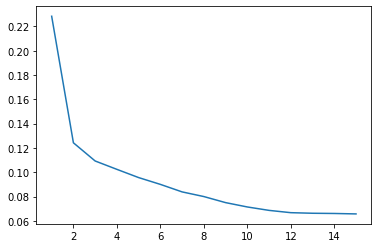

In [34]:
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)

    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    
###loss vs epoch graph at last
